In [1]:
# Input data
import scipy.io as spio
import numpy as np

new_executive = spio.loadmat(file_name='../data/bci_EEG_data-new/new_executive.mat')
new_executive_data = new_executive['new_executive']
print(new_executive_data.shape, new_executive_data.dtype)

new_executive_data_transposed = new_executive_data.transpose(2, 0, 1)
print(new_executive_data_transposed.shape)

# Deviding the input data into train and validation
# For creating the training and testing set, 30% percent of each subject is considered as test and
# 70% of each subject is conidered as training.
length = int(new_executive_data_transposed.shape[0] * 0.30)
# length

train_data_all = new_executive_data_transposed[:-length]
test_data = new_executive_data_transposed[-length:]

print(new_executive_data_transposed.shape, new_executive_data_transposed.dtype, 
 train_data_all.shape, train_data_all.dtype, 
 test_data.shape, test_data.dtype)

# 30% of the total training data is validation,
# 70% of the total training data is training
# This is applied to every single subject data.
length2 = int(train_data_all.shape[0] * 0.30)
# length2

train_data = train_data_all[:-length2]
valid_data = train_data_all[-length2:]

print(train_data_all.shape, train_data_all.dtype, 
 train_data.shape, train_data.dtype, 
 valid_data.shape, valid_data.dtype)

(3072, 13, 1380) float64
(1380, 3072, 13)
(1380, 3072, 13) float64 (966, 3072, 13) float64 (414, 3072, 13) float64
(966, 3072, 13) float64 (677, 3072, 13) float64 (289, 3072, 13) float64


In [36]:
# Output data: class labels
new_executive_label = spio.loadmat(file_name='../data/bci_EEG_data-new/new_executive_label.mat')
# new_executive_label.keys()
new_executive_label_all = new_executive_label['new_executive_label']
print(new_executive_label_all.shape, new_executive_label_all.dtype, 
      new_executive_label_all.max(axis=0))

label_train_all = new_executive_label_all[:-length]
label_test = new_executive_label_all[-length:]

print(new_executive_label_all.shape, new_executive_label_all.dtype,
 label_test.shape, label_test.dtype, 
 label_train_all.shape, label_train_all.dtype)

label_train = label_train_all[:-length2]
label_valid = label_train_all[-length2:]
print(label_train.shape, label_valid.shape)

(1380, 1) uint16 [3]
(1380, 1) uint16 (414, 1) uint16 (966, 1) uint16
(677, 1) (289, 1)


In [2]:
# # Normalizing input data
# def normalize(inputs, inputs_all):
#     return (inputs - inputs_all.mean(axis=0)[None,:,:]) / inputs_all.std(axis=0)[None,:,:]
# Yalda suggested this normalization.
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

# Standardize/normalize train and test
# X_train_norm_all = normalize(inputs=FacesDataTrain, inputs_all=FacesDataAll)
X_train_norm = normalize(inputs=train_data)
X_valid_norm = normalize(inputs=valid_data)
X_test_norm = normalize(inputs=test_data)

print(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

(677, 3072, 13) float64 (289, 3072, 13) float64 (414, 3072, 13) float64


In [3]:
### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 10 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
# n_classes = int(new_executive_label_all.max(axis=0) + 1)
n_classes = int(new_executive_label_all.max(axis=0))
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.001 #1e-3
epochs = 1000 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 67 3072 13


NameError: name 'new_executive_label_all' is not defined

In [39]:
Y_train = np.array(label_train, dtype=int).reshape(-1)
Y_valid = np.array(label_valid, dtype=int).reshape(-1)
Y_test = np.array(label_test, dtype=int).reshape(-1)

Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

print(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

print(Y_train_onehot.dtype, Y_valid_onehot.dtype, Y_test_onehot.dtype,
 X_train_norm.dtype, X_valid_norm.dtype, X_test_norm.dtype)

(677, 3) (289, 3) (414, 3) (677, 3072, 13) (289, 3072, 13) (414, 3072, 13)
float64 float64 float64 float64 float64 float64


In [40]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [41]:
#  Buffering/ placeholders to transfer the data from py to tf
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [42]:
# Forward pass: Convolutional Layers, FC Layer, and Output layer
# 677, 3072, 13
# (batch, 3072, 13) --> (batch, 1534, 26)
# (3072 - 6 + 0)/2 + 1 = (3066/2)+1= 1533 +1 = 1534
# 2/6 with strides/kernel_size is 33.333% non-overlap/diff region and 
# 66.666% overlapping window/ common region
# tf.layers.conv2d (actually _Conv) uses tf.nn.convolution as the backend. 
# I would use tf.nn.conv2d when loading a pretrained model, 
# and tf.layers.conv2d for a model trained from scratch.
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=26, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(in_conv.shape, out_conv.shape)

# To reduce the size for memory efficiency & equivariancy/invariency/ minicolumns
# (batch, 1534, 26) --> (batch, 511, 26)
# (1534 - 4 + 0)/3 + 1 = (1530/3)+1= 510 +1 = 511
# 3/4 with strides/kernel_size is 
# 75% non-overlap/diff region and 
# 25% overlapping window/ common region
in_pool = out_conv
out_pool = tf.layers.max_pooling1d(inputs=in_pool, pool_size=4, strides=3, padding='valid')
print(in_pool.shape, out_pool.shape)

# (batch, 511, 26) --> (batch, 254, 52)
# (511 - 5 + 0)/2 + 1 = (506/2)+1= 253+1= 254
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 
# 60% overlapping window/ common region
in_conv = out_pool
out_conv = tf.layers.conv1d(inputs=in_conv, filters=52, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(in_conv.shape, out_conv.shape)

# To reduce the size for memory efficiency & equivariancy/invariency/ minicolumns
# (batch, 254, 52) --> (batch, 25, 52)
# (254 - 14 + 0)/10 + 1 = (240/10)+1= 24 +1 = 25
# 10/14 with strides/kernel_size is 
# ~66.666% non-overlap/diff region and 
# ~33.33% overlapping window/ common region
in_pool = out_conv
out_pool = tf.layers.max_pooling1d(inputs=in_pool, pool_size=14, strides=10, padding='valid')
print(in_pool.shape, out_pool.shape)

# (batch, 25, 52) --> (batch, 25*52) --> (batch, 25*52*2)
in_fc = tf.reshape(tensor=out_pool, shape=(-1, 25*52))
out_fc = tf.layers.dense(inputs=in_fc, units=25*52*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(out_pool.shape, in_fc.shape, out_fc.shape)

# (batch, 25*52*2) --> (batch, 3) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(out_fc.shape, logits.shape)

(?, 3072, 13) (?, 1534, 26)
(?, 1534, 26) (?, 511, 26)
(?, 511, 26) (?, 254, 52)
(?, 254, 52) (?, 25, 52)
(?, 25, 52) (?, 1300) (?, 2600)
(?, 2600) (?, 3)


In [43]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print(correct_pred, accuracy)

Tensor("Equal_3:0", shape=(?,), dtype=bool) Tensor("accuracy_3:0", shape=(), dtype=float32)


In [44]:
# Train the network
# Plotting the acc and loss curve
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
       
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################################ Validation
            # Loop over batches
            acc_batch, loss_batch = [], []
            for x, y in get_batches(X_valid_norm, Y_train_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_:x, labels_:y, keep_prob_:1.0}
                loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                
                # list of accuracy and loss for validation batch
                acc_batch.append(acc)
                loss_batch.append(loss)

            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info in every iteration/epochs
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
        
    ################################ Test
    # Loop over batches
    acc_batch, loss_batch = [], []
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_:x, labels_:y, keep_prob_:1.0}
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)

        # Initialize 
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:6f}".format(np.mean(acc_batch)))

Epoch: 1/1000 Train loss: 13.605702 Valid loss: 4.456787 Train acc: 0.335821 Valid acc: 0.333209
Epoch: 2/1000 Train loss: 7.804236 Valid loss: 2.821270 Train acc: 0.338806 Valid acc: 0.331903
Epoch: 3/1000 Train loss: 5.627068 Valid loss: 2.248756 Train acc: 0.343781 Valid acc: 0.332338
Epoch: 4/1000 Train loss: 4.513288 Valid loss: 1.961892 Train acc: 0.336567 Valid acc: 0.334422
Epoch: 5/1000 Train loss: 3.831779 Valid loss: 1.789342 Train acc: 0.342985 Valid acc: 0.337388
Epoch: 6/1000 Train loss: 3.375536 Valid loss: 1.674261 Train acc: 0.351493 Valid acc: 0.339801
Epoch: 7/1000 Train loss: 3.050729 Valid loss: 1.592064 Train acc: 0.355011 Valid acc: 0.340672
Epoch: 8/1000 Train loss: 2.805316 Valid loss: 1.530447 Train acc: 0.356343 Valid acc: 0.341511
Epoch: 9/1000 Train loss: 2.614046 Valid loss: 1.482548 Train acc: 0.360862 Valid acc: 0.341086
Epoch: 10/1000 Train loss: 2.459950 Valid loss: 1.444232 Train acc: 0.367313 Valid acc: 0.340634
Epoch: 11/1000 Train loss: 2.333438 Va

Epoch: 86/1000 Train loss: 0.860180 Valid loss: 1.225537 Train acc: 0.663051 Valid acc: 0.336355
Epoch: 87/1000 Train loss: 0.852342 Valid loss: 1.227722 Train acc: 0.666272 Valid acc: 0.336108
Epoch: 88/1000 Train loss: 0.844856 Valid loss: 1.230098 Train acc: 0.669183 Valid acc: 0.335974
Epoch: 89/1000 Train loss: 0.837512 Valid loss: 1.232190 Train acc: 0.672145 Valid acc: 0.335796
Epoch: 90/1000 Train loss: 0.831041 Valid loss: 1.234409 Train acc: 0.674677 Valid acc: 0.335871
Epoch: 91/1000 Train loss: 0.824219 Valid loss: 1.236567 Train acc: 0.677284 Valid acc: 0.335804
Epoch: 92/1000 Train loss: 0.817198 Valid loss: 1.239498 Train acc: 0.680127 Valid acc: 0.335622
Epoch: 93/1000 Train loss: 0.810298 Valid loss: 1.242108 Train acc: 0.682892 Valid acc: 0.335331
Epoch: 94/1000 Train loss: 0.804035 Valid loss: 1.244456 Train acc: 0.685487 Valid acc: 0.335039
Epoch: 95/1000 Train loss: 0.797438 Valid loss: 1.246164 Train acc: 0.688154 Valid acc: 0.334709
Epoch: 96/1000 Train loss: 0.7

Epoch: 170/1000 Train loss: 0.486600 Valid loss: 1.434782 Train acc: 0.812283 Valid acc: 0.321993
Epoch: 171/1000 Train loss: 0.483974 Valid loss: 1.437083 Train acc: 0.813311 Valid acc: 0.321921
Epoch: 172/1000 Train loss: 0.481367 Valid loss: 1.439766 Train acc: 0.814327 Valid acc: 0.321818
Epoch: 173/1000 Train loss: 0.478981 Valid loss: 1.442243 Train acc: 0.815296 Valid acc: 0.321661
Epoch: 174/1000 Train loss: 0.476660 Valid loss: 1.444795 Train acc: 0.816221 Valid acc: 0.321470
Epoch: 175/1000 Train loss: 0.474227 Valid loss: 1.446941 Train acc: 0.817143 Valid acc: 0.321213
Epoch: 176/1000 Train loss: 0.471724 Valid loss: 1.449156 Train acc: 0.818148 Valid acc: 0.321078
Epoch: 177/1000 Train loss: 0.469336 Valid loss: 1.451099 Train acc: 0.819074 Valid acc: 0.320940
Epoch: 178/1000 Train loss: 0.467014 Valid loss: 1.453417 Train acc: 0.819973 Valid acc: 0.320751
Epoch: 179/1000 Train loss: 0.464693 Valid loss: 1.455560 Train acc: 0.820870 Valid acc: 0.320533
Epoch: 180/1000 Trai

Epoch: 254/1000 Train loss: 0.338542 Valid loss: 1.596501 Train acc: 0.870167 Valid acc: 0.311438
Epoch: 255/1000 Train loss: 0.337330 Valid loss: 1.598676 Train acc: 0.870629 Valid acc: 0.311378
Epoch: 256/1000 Train loss: 0.336055 Valid loss: 1.600599 Train acc: 0.871129 Valid acc: 0.311397
Epoch: 257/1000 Train loss: 0.334826 Valid loss: 1.602557 Train acc: 0.871607 Valid acc: 0.311365
Epoch: 258/1000 Train loss: 0.333599 Valid loss: 1.604672 Train acc: 0.872081 Valid acc: 0.311362
Epoch: 259/1000 Train loss: 0.332413 Valid loss: 1.606811 Train acc: 0.872541 Valid acc: 0.311325
Epoch: 260/1000 Train loss: 0.331233 Valid loss: 1.608975 Train acc: 0.872991 Valid acc: 0.311277
Epoch: 261/1000 Train loss: 0.330038 Valid loss: 1.610499 Train acc: 0.873443 Valid acc: 0.311220
Epoch: 262/1000 Train loss: 0.328855 Valid loss: 1.612203 Train acc: 0.873909 Valid acc: 0.311203
Epoch: 263/1000 Train loss: 0.327659 Valid loss: 1.613842 Train acc: 0.874371 Valid acc: 0.311173
Epoch: 264/1000 Trai

Epoch: 338/1000 Train loss: 0.262617 Valid loss: 1.712946 Train acc: 0.900018 Valid acc: 0.307894
Epoch: 339/1000 Train loss: 0.261955 Valid loss: 1.713762 Train acc: 0.900269 Valid acc: 0.307871
Epoch: 340/1000 Train loss: 0.261257 Valid loss: 1.714811 Train acc: 0.900544 Valid acc: 0.307872
Epoch: 341/1000 Train loss: 0.260571 Valid loss: 1.715920 Train acc: 0.900801 Valid acc: 0.307946
Epoch: 342/1000 Train loss: 0.259903 Valid loss: 1.717316 Train acc: 0.901061 Valid acc: 0.307933
Epoch: 343/1000 Train loss: 0.259226 Valid loss: 1.718384 Train acc: 0.901314 Valid acc: 0.307934
Epoch: 344/1000 Train loss: 0.258513 Valid loss: 1.719440 Train acc: 0.901588 Valid acc: 0.307936
Epoch: 345/1000 Train loss: 0.257832 Valid loss: 1.720263 Train acc: 0.901856 Valid acc: 0.307928
Epoch: 346/1000 Train loss: 0.257252 Valid loss: 1.721218 Train acc: 0.902092 Valid acc: 0.307879
Epoch: 347/1000 Train loss: 0.256575 Valid loss: 1.722607 Train acc: 0.902353 Valid acc: 0.307850
Epoch: 348/1000 Trai

Epoch: 422/1000 Train loss: 0.216491 Valid loss: 1.819852 Train acc: 0.918063 Valid acc: 0.306015
Epoch: 423/1000 Train loss: 0.216037 Valid loss: 1.821036 Train acc: 0.918239 Valid acc: 0.305963
Epoch: 424/1000 Train loss: 0.215549 Valid loss: 1.822117 Train acc: 0.918421 Valid acc: 0.305915
Epoch: 425/1000 Train loss: 0.215088 Valid loss: 1.823203 Train acc: 0.918595 Valid acc: 0.305889
Epoch: 426/1000 Train loss: 0.214602 Valid loss: 1.824334 Train acc: 0.918783 Valid acc: 0.305823
Epoch: 427/1000 Train loss: 0.214122 Valid loss: 1.825514 Train acc: 0.918959 Valid acc: 0.305770
Epoch: 428/1000 Train loss: 0.213652 Valid loss: 1.826600 Train acc: 0.919134 Valid acc: 0.305737
Epoch: 429/1000 Train loss: 0.213172 Valid loss: 1.827752 Train acc: 0.919320 Valid acc: 0.305734
Epoch: 430/1000 Train loss: 0.212732 Valid loss: 1.829156 Train acc: 0.919483 Valid acc: 0.305729
Epoch: 431/1000 Train loss: 0.212354 Valid loss: 1.830899 Train acc: 0.919635 Valid acc: 0.305722
Epoch: 432/1000 Trai

Epoch: 506/1000 Train loss: 0.184213 Valid loss: 1.903382 Train acc: 0.930544 Valid acc: 0.305491
Epoch: 507/1000 Train loss: 0.183884 Valid loss: 1.904629 Train acc: 0.930669 Valid acc: 0.305481
Epoch: 508/1000 Train loss: 0.183539 Valid loss: 1.905652 Train acc: 0.930803 Valid acc: 0.305503
Epoch: 509/1000 Train loss: 0.183239 Valid loss: 1.906829 Train acc: 0.930924 Valid acc: 0.305510
Epoch: 510/1000 Train loss: 0.182965 Valid loss: 1.907950 Train acc: 0.931042 Valid acc: 0.305447
Epoch: 511/1000 Train loss: 0.182657 Valid loss: 1.909188 Train acc: 0.931165 Valid acc: 0.305401
Epoch: 512/1000 Train loss: 0.182331 Valid loss: 1.910985 Train acc: 0.931285 Valid acc: 0.305365
Epoch: 513/1000 Train loss: 0.181991 Valid loss: 1.912558 Train acc: 0.931413 Valid acc: 0.305358
Epoch: 514/1000 Train loss: 0.181672 Valid loss: 1.913990 Train acc: 0.931532 Valid acc: 0.305321
Epoch: 515/1000 Train loss: 0.181393 Valid loss: 1.915477 Train acc: 0.931656 Valid acc: 0.305282
Epoch: 516/1000 Trai

Epoch: 590/1000 Train loss: 0.161860 Valid loss: 1.992334 Train acc: 0.939375 Valid acc: 0.304351
Epoch: 591/1000 Train loss: 0.161633 Valid loss: 1.993435 Train acc: 0.939463 Valid acc: 0.304355
Epoch: 592/1000 Train loss: 0.161407 Valid loss: 1.994870 Train acc: 0.939552 Valid acc: 0.304333
Epoch: 593/1000 Train loss: 0.161172 Valid loss: 1.996060 Train acc: 0.939644 Valid acc: 0.304330
Epoch: 594/1000 Train loss: 0.160925 Valid loss: 1.996807 Train acc: 0.939738 Valid acc: 0.304306
Epoch: 595/1000 Train loss: 0.160687 Valid loss: 1.997729 Train acc: 0.939827 Valid acc: 0.304286
Epoch: 596/1000 Train loss: 0.160438 Valid loss: 1.999095 Train acc: 0.939923 Valid acc: 0.304266
Epoch: 597/1000 Train loss: 0.160198 Valid loss: 2.000802 Train acc: 0.940019 Valid acc: 0.304218
Epoch: 598/1000 Train loss: 0.159973 Valid loss: 2.002082 Train acc: 0.940106 Valid acc: 0.304183
Epoch: 599/1000 Train loss: 0.159744 Valid loss: 2.003194 Train acc: 0.940199 Valid acc: 0.304133
Epoch: 600/1000 Trai

Epoch: 674/1000 Train loss: 0.144937 Valid loss: 2.078542 Train acc: 0.946034 Valid acc: 0.303819
Epoch: 675/1000 Train loss: 0.144796 Valid loss: 2.079869 Train acc: 0.946098 Valid acc: 0.303776
Epoch: 676/1000 Train loss: 0.144611 Valid loss: 2.080993 Train acc: 0.946165 Valid acc: 0.303733
Epoch: 677/1000 Train loss: 0.144456 Valid loss: 2.082199 Train acc: 0.946229 Valid acc: 0.303716
Epoch: 678/1000 Train loss: 0.144259 Valid loss: 2.083701 Train acc: 0.946302 Valid acc: 0.303678
Epoch: 679/1000 Train loss: 0.144081 Valid loss: 2.085406 Train acc: 0.946368 Valid acc: 0.303690
Epoch: 680/1000 Train loss: 0.143929 Valid loss: 2.087323 Train acc: 0.946431 Valid acc: 0.303716
Epoch: 681/1000 Train loss: 0.143804 Valid loss: 2.089056 Train acc: 0.946490 Valid acc: 0.303734
Epoch: 682/1000 Train loss: 0.143613 Valid loss: 2.090393 Train acc: 0.946560 Valid acc: 0.303747
Epoch: 683/1000 Train loss: 0.143430 Valid loss: 2.091723 Train acc: 0.946629 Valid acc: 0.303766
Epoch: 684/1000 Trai

Epoch: 758/1000 Train loss: 0.131281 Valid loss: 2.178930 Train acc: 0.951394 Valid acc: 0.303371
Epoch: 759/1000 Train loss: 0.131111 Valid loss: 2.180213 Train acc: 0.951456 Valid acc: 0.303371
Epoch: 760/1000 Train loss: 0.130946 Valid loss: 2.181449 Train acc: 0.951518 Valid acc: 0.303384
Epoch: 761/1000 Train loss: 0.130814 Valid loss: 2.182651 Train acc: 0.951578 Valid acc: 0.303396
Epoch: 762/1000 Train loss: 0.130669 Valid loss: 2.183684 Train acc: 0.951639 Valid acc: 0.303413
Epoch: 763/1000 Train loss: 0.130546 Valid loss: 2.184579 Train acc: 0.951697 Valid acc: 0.303434
Epoch: 764/1000 Train loss: 0.130402 Valid loss: 2.185658 Train acc: 0.951752 Valid acc: 0.303462
Epoch: 765/1000 Train loss: 0.130255 Valid loss: 2.186911 Train acc: 0.951810 Valid acc: 0.303487
Epoch: 766/1000 Train loss: 0.130114 Valid loss: 2.188033 Train acc: 0.951869 Valid acc: 0.303494
Epoch: 767/1000 Train loss: 0.129959 Valid loss: 2.189013 Train acc: 0.951927 Valid acc: 0.303481
Epoch: 768/1000 Trai

Epoch: 842/1000 Train loss: 0.120512 Valid loss: 2.243170 Train acc: 0.955736 Valid acc: 0.304070
Epoch: 843/1000 Train loss: 0.120373 Valid loss: 2.243891 Train acc: 0.955787 Valid acc: 0.304075
Epoch: 844/1000 Train loss: 0.120240 Valid loss: 2.244788 Train acc: 0.955836 Valid acc: 0.304081
Epoch: 845/1000 Train loss: 0.120143 Valid loss: 2.245736 Train acc: 0.955883 Valid acc: 0.304106
Epoch: 846/1000 Train loss: 0.120015 Valid loss: 2.246374 Train acc: 0.955928 Valid acc: 0.304127
Epoch: 847/1000 Train loss: 0.119920 Valid loss: 2.247038 Train acc: 0.955973 Valid acc: 0.304141
Epoch: 848/1000 Train loss: 0.119787 Valid loss: 2.247733 Train acc: 0.956021 Valid acc: 0.304136
Epoch: 849/1000 Train loss: 0.119652 Valid loss: 2.248425 Train acc: 0.956070 Valid acc: 0.304137
Epoch: 850/1000 Train loss: 0.119531 Valid loss: 2.249142 Train acc: 0.956116 Valid acc: 0.304147
Epoch: 851/1000 Train loss: 0.119395 Valid loss: 2.250064 Train acc: 0.956166 Valid acc: 0.304148
Epoch: 852/1000 Trai

Epoch: 926/1000 Train loss: 0.111855 Valid loss: 2.327996 Train acc: 0.959242 Valid acc: 0.303884
Epoch: 927/1000 Train loss: 0.111747 Valid loss: 2.329298 Train acc: 0.959281 Valid acc: 0.303898
Epoch: 928/1000 Train loss: 0.111649 Valid loss: 2.330309 Train acc: 0.959322 Valid acc: 0.303929
Epoch: 929/1000 Train loss: 0.111539 Valid loss: 2.331255 Train acc: 0.959363 Valid acc: 0.303952
Epoch: 930/1000 Train loss: 0.111425 Valid loss: 2.332402 Train acc: 0.959401 Valid acc: 0.303973
Epoch: 931/1000 Train loss: 0.111314 Valid loss: 2.333484 Train acc: 0.959440 Valid acc: 0.303975
Epoch: 932/1000 Train loss: 0.111231 Valid loss: 2.334366 Train acc: 0.959474 Valid acc: 0.303988
Epoch: 933/1000 Train loss: 0.111124 Valid loss: 2.335087 Train acc: 0.959511 Valid acc: 0.303987
Epoch: 934/1000 Train loss: 0.111018 Valid loss: 2.335846 Train acc: 0.959551 Valid acc: 0.303986
Epoch: 935/1000 Train loss: 0.110912 Valid loss: 2.336590 Train acc: 0.959593 Valid acc: 0.303986
Epoch: 936/1000 Trai

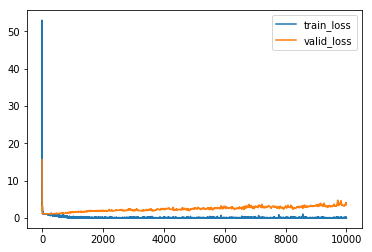

In [45]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

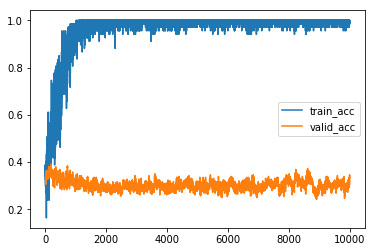

In [46]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()